In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, recall_score)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [133]:
%pip install scikit-learn
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [134]:
df = pd.read_csv(r"C:\Users\Avnish Singh\Downloads\Loan_Default.csv")

In [135]:
COST_FN = 100000 # cost when approving a borrower who defaults
COST_FP = 1000 # cost when rejecting a borrower who would have repaid
RANDOM_STATE = 42

In [136]:

drop_cols = ['ID', 'year', 'open_credit', 'Region']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])


num_cols = ['term','rate_of_interest','Interest_rate_spread','Upfront_charges',
'income','property_value','LTV','dtir1']
cat_cols = ['loan_limit','approv_in_adv','loan_purpose','Neg_ammortization']



In [137]:
for col in num_cols:
    if col in df.columns:
       df[col] = pd.to_numeric(df[col], errors='coerce')
       df[col] = df[col].fillna(df[col].median())

In [138]:
for col in cat_cols:
    if col in df.columns:
      df[col] = df[col].fillna(df[col].mode()[0])

In [139]:
df.isna().sum()

loan_limit                     0
Gender                         0
approv_in_adv                  0
loan_type                      0
loan_purpose                   0
Credit_Worthiness              0
business_or_commercial         0
loan_amount                    0
rate_of_interest               0
Interest_rate_spread           0
Upfront_charges                0
term                           0
Neg_ammortization              0
interest_only                  0
lump_sum_payment               0
property_value                 0
construction_type              0
occupancy_type                 0
Secured_by                     0
total_units                    0
income                         0
credit_type                    0
Credit_Score                   0
co-applicant_credit_type       0
age                          200
submission_of_application    200
LTV                            0
Security_Type                  0
Status                         0
dtir1                          0
dtype: int

In [140]:
y = df['Status'].astype(int) 
X = df.drop(columns=['Status'])

In [141]:
X = pd.get_dummies(X, drop_first=True)
# cleaning feature names for XGBoost
X.columns = X.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)

In [142]:
numeric_after = X.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X[numeric_after] = scaler.fit_transform(X[numeric_after])


In [143]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [144]:
from sklearn.metrics import confusion_matrix


def business_cost(y_true, y_prob, threshold, cost_fn=COST_FN, cost_fp=COST_FP):
   preds = (y_prob >= threshold).astype(int)
   tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
   total_cost = fn * cost_fn + fp * cost_fp
   return total_cost, {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}

Logistic @0.5
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     22406
           1       0.66      0.71      0.68      7328

    accuracy                           0.84     29734
   macro avg       0.78      0.79      0.79     29734
weighted avg       0.84      0.84      0.84     29734

ROC AUC: 0.8670477634948064

Best threshold: 0.02
Best business cost: 22402000

Classification Report @best t
              precision    recall  f1-score   support

           0       0.99      0.00      0.01     22406
           1       0.25      1.00      0.40      7328

    accuracy                           0.25     29734
   macro avg       0.62      0.50      0.20     29734
weighted avg       0.81      0.25      0.10     29734

Confusion: [[  104 22302]
 [    1  7327]]


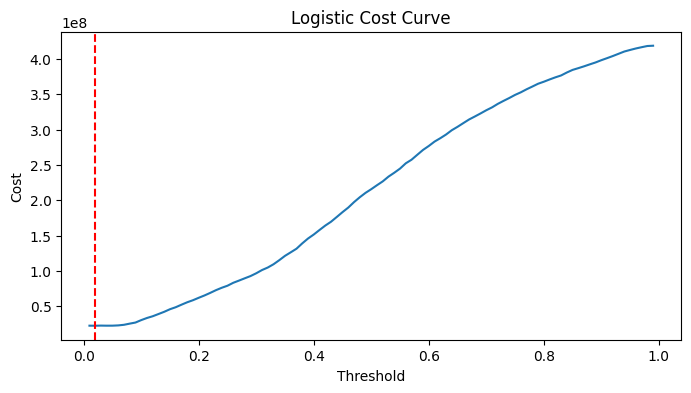

In [145]:

log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear"
)

log_model.fit(X_train, y_train)
log_probs = log_model.predict_proba(X_test)[:, 1]

print("Logistic @0.5")
print(classification_report(y_test, (log_probs >= 0.5).astype(int)))
print("ROC AUC:", roc_auc_score(y_test, log_probs))


thresholds = np.linspace(0.01, 0.99, 99)
costs = []

for t in thresholds:
    c, _ = business_cost(y_test, log_probs, t)
    costs.append(c)

best_t = thresholds[np.argmin(costs)]
best_cost = min(costs)

print("\nBest threshold:", best_t)
print("Best business cost:", best_cost)

log_pred_best = (log_probs >= best_t).astype(int)

print("\nClassification Report @best t")
print(classification_report(y_test, log_pred_best))
print("Confusion:", confusion_matrix(y_test, log_pred_best))



plt.figure(figsize=(8,4))
plt.plot(thresholds, costs)
plt.axvline(best_t, color='red', linestyle='--')
plt.title("Logistic Cost Curve")
plt.xlabel("Threshold")
plt.ylabel("Cost")
plt.show()

In [146]:
y_test.value_counts()

Status
0    22406
1     7328
Name: count, dtype: int64


XGBoost @0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734

ROC AUC: 0.9999965771605936

Best threshold for XGBoost (min cost): 0.99
Business cost at best threshold: 1000

Classification at best threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734

Confusion matrix: [[22405     1]
 [    0  7328]]


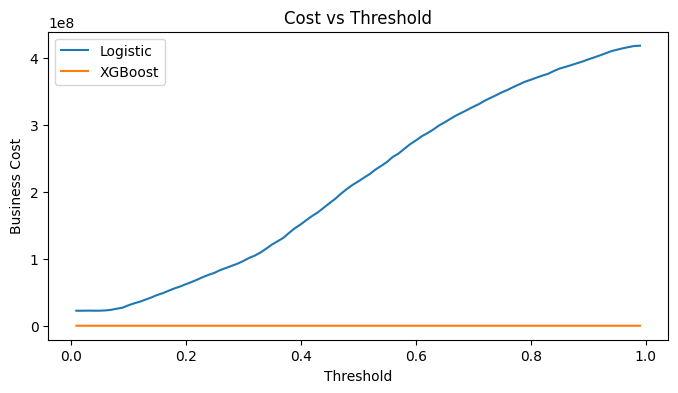

In [147]:
# prepare scale_pos_weight safely
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos


xgb = XGBClassifier(
n_estimators=300,
learning_rate=0.05,
max_depth=6,
subsample=0.8,
colsample_bytree=0.8,
scale_pos_weight=scale_pos_weight,
eval_metric='logloss',
use_label_encoder=False,
random_state=RANDOM_STATE
)


xgb.fit(X_train, y_train)


xgb_probs = xgb.predict_proba(X_test)[:,1]
xgb_pred_05 = (xgb_probs >= 0.5).astype(int)
print('\nXGBoost @0.5')
print(classification_report(y_test, xgb_pred_05))
print('ROC AUC:', roc_auc_score(y_test, xgb_probs))


# search best threshold for XGBoost
costs_xgb = []
for t in thresholds:
   c, _ = business_cost(y_test, xgb_probs, t)
   costs_xgb.append(c)


best_t_xgb = thresholds[np.argmin(costs_xgb)]
best_cost_xgb = min(costs_xgb)
print('\nBest threshold for XGBoost (min cost):', best_t_xgb)
print('Business cost at best threshold:', best_cost_xgb)


xgb_pred_best = (xgb_probs >= best_t_xgb).astype(int)
print('\nClassification at best threshold:')
print(classification_report(y_test, xgb_pred_best))
print('Confusion matrix:', confusion_matrix(y_test, xgb_pred_best))


# plot cost curves comparison
plt.figure(figsize=(8,4))
plt.plot(thresholds, costs, label='Logistic')
plt.plot(thresholds, costs_xgb, label='XGBoost')
plt.xlabel('Threshold')
plt.ylabel('Business Cost')
plt.title('Cost vs Threshold')
plt.legend()
plt.show()

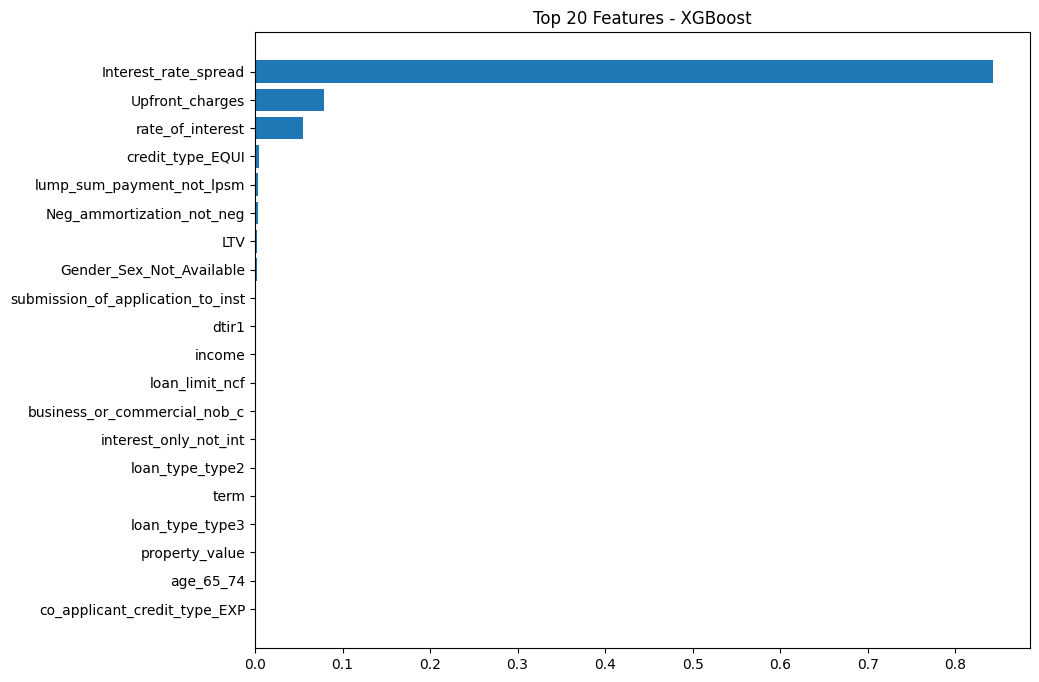

In [148]:
fi = xgb.feature_importances_
indices = np.argsort(fi)[-20:]
plt.figure(figsize=(10,8))
plt.barh(range(len(indices)), fi[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.title('Top 20 Features - XGBoost')
plt.show()

In [150]:
print('--- Final Summary ---')
print('Logistic best cost:', best_cost, 'at threshold', best_t)
print('Logistic ROC AUC:' , roc_auc_score(y_test,log_probs))
print('XGBoost best cost:', best_cost_xgb, 'at threshold', best_t_xgb)
print('XGBoost ROC AUC:', roc_auc_score(y_test, xgb_probs))

--- Final Summary ---
Logistic best cost: 22402000 at threshold 0.02
Logistic ROC AUC: 0.8670477634948064
XGBoost best cost: 1000 at threshold 0.99
XGBoost ROC AUC: 0.9999965771605936
